In [1]:
# Install codeium-jupyter autocompletion software
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U codeium-jupyter

In [2]:
# Import dependencies
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import numpy as np
from matplotlib.gridspec import GridSpec
from numba import njit
from scipy.optimize import minimize, Bounds
from sympy import symbols, solve, lambdify

In [3]:
import json
import numpy as np
with open("archive/data.json") as f:
    DATA = json.load(f)
    cpd, rot3, bes1, auxin, length, position = DATA.values()

def create_vector_function(params):
    xp, yp, degree, xlim, ylim = params.values()
    f = np.poly1d(np.polyfit(xp, yp, degree))
    return np.vectorize(lambda p : f(p) if p < xlim[1] else f(xlim[1]))

def dfuncs():
    return {
        "position_to_cpd": create_vector_function(cpd),
        "position_to_rot3": create_vector_function(rot3),
        "position_to_bes1": create_vector_function(bes1),
        "position_to_auxin": create_vector_function(auxin),
        "position_to_length": create_vector_function(length),
        "time_to_position": create_vector_function(position)
    }

In [4]:
# Get experimental data from the dfuncs module
CPD, ROT3, BES1, AUXIN, SIZE, POSITION = dfuncs().values()
STEP = 0.15

# Define the time step, BR, and auxin vectors
vT = np.arange(0, 15 + STEP, STEP)
vB = (CPD(POSITION(vT)) + ROT3(POSITION(vT))) / 100
vA = AUXIN(POSITION(vT))

# Define the vectors of experimental data
vSIZE = SIZE(POSITION(vT))
vBES1 = BES1(POSITION(vT)) / 10

In [5]:
def setup(config):

    # Define parameters and variables
    params = symbols('c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M')
    c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M = params
    
    # Define the symbols representing hormone levels
    C, R0, RB, M, B, A, L = symbols('C R0 RB M B A L')

    # Construct some expressions based on the configuration
    sq, hill, auxin, lmul, tfbs = config
    B_1 = B**2 if sq else B
    B_2 = (B_1 / (1 + b * B_1)) if hill else B_1
    L_m = L if lmul else 1
    L_1 = (1 + (g_A * A)) if auxin else 1
    L_2 = (1 + (g_M * M)) if tfbs else 1
            
    # Write the hormone equations down as a system
    hormone_eqn = [
        c_max - (1 + q * RB) * C,
        u * (1 + v * C) - (k_on * R0 * B_2) + (k_off * RB) - R0,
        (k_on * R0 * B_2) - (1 + k_off) * RB,
        (a_M * C / L) - M
    ]

    # Solve hormone equations, choosing the second root to ensure positive solutions
    hormone_ss = solve(hormone_eqn, [C, R0, RB, M], dict = True)[-1]
    fC, fR0, fRB, fM = [njit(lambdify([*params, B, L], hormone_ss[h])) for h in [C, R0, RB, M]]

    # Write down the growth equation and convert it into a lambda function
    growth_eqn = (g_B * RB * L_m) / (L_1 * L_2)
    fdL = njit(lambdify([*params, RB, A, M, L], growth_eqn))

    # Return the list of lambda functions
    return [fC, fR0, fRB, fM, fdL]

In [6]:
# Create the space of configuration tuples
config_space = list(itertools.product([False, True], repeat=5))

# Create the simulation tuples (description, funcs)
simulations = [(config, setup(config)) for config in config_space]

In [7]:
@njit
def NRMSE(predicted, observed):
    rmse = np.sqrt(np.sum(np.square(predicted - observed)) / predicted.shape[0])
    return rmse / np.mean(observed)

@njit
def simulate_cell(params, C, R0, RB, M, dL):

    # Unpack the list of parameters
    c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M = params
    
    # Initialize hormone values (c, r0, rb, m) and length value
    vC, c   = np.array([np.float64(x) for x in range(0)]), 0
    vR0, r0 = np.array([np.float64(x) for x in range(0)]), 0
    vRB, rb = np.array([np.float64(x) for x in range(0)]), 0
    vM, m   = np.array([np.float64(x) for x in range(0)]), 0
    vL, l   = np.array([np.float64(x) for x in range(0)]), vSIZE[0]
    
    # Run the simulation one time step at a time
    for i in range(vB.shape[0]):

        # Get the current time step and external hormone values
        b = vB[i]
        a = vA[i]
        
        # Update each of the steady-state hormone values
        c  =  C(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, b, l)
        r0 = R0(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, b, l)
        rb = RB(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, b, l)
        m  =  M(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, b, l)

        # Append the steady-state hormone values to the hormone vectors
        vC = np.append(vC, c)
        vR0 = np.append(vR0, r0)
        vRB = np.append(vRB, rb)
        vM = np.append(vM, m)

        # Update the length vector
        l = l + dL(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, rb, a, m, l) * STEP
        vL = np.append(vL, l)
    
    # Compute the BR signalling and NRMSE of trial run
    vS = vRB * q
    error = NRMSE(vL, vSIZE) + NRMSE(vS, vBES1)
    return [vC, vR0, vS, vM, vL], error

## Model Fitting

In [8]:
# Convert configuration tuple into a written description
def get_description(config):
    d = []
    d.append(r"$B^2$" if config[0] else r"$B$") 
    if config[1]: d.append("Hill")
    if config[2]: d.append("Auxin")
    if config[3]: d.append("L-Scaled")
    if config[4]: d.append("TFBs")
    return ", ".join(d)

In [9]:
# Run each of the simulations and print the best error
results = []
for sim in simulations:

    # Define a cost function with the given simulation
    config, (C, R0, RB, M, dL) = sim
    description = get_description(config)
    cost = lambda params : simulate_cell(params, C, R0, RB, M, dL)[-1]

    # Find the parameters of best fit
    fit = minimize(
        cost, 
        np.ones(11), 
        method = "trust-constr",
        bounds = Bounds(0.001, 1000), 
        options = {"maxiter": 10000}
    )

    # Run a simulation with the optimal parameters and log
    data, error = simulate_cell(fit.x, C, R0, RB, M, dL)
    print(description)
    print("Success: ", fit.success, fit.message)
    print("Params: ", [round(n, 3) for n in fit.x])
    print("Error: ", error, "\n")

    # Add the simulation data to the results results
    results.append((config, data, error))

/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$
Success:  True `xtol` termination condition is satisfied.
Params:  [0.003, 71.135, 284.681, 0.002, 0.001, 26.557, 27.209, 35.328, 53.242, 25.799, 29.124]
Error:  0.7680072676603642 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [3.014, 2.078, 226.028, 0.001, 0.038, 22.609, 25.427, 73.75, 308.597, 18.812, 59.286]
Error:  0.46402967326279904 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, L-Scaled
Success:  True `xtol` termination condition is satisfied.
Params:  [0.002, 74.773, 97.113, 0.009, 0.002, 19.197, 15.926, 3.137, 3.375, 20.655, 20.255]
Error:  0.5480927402154281 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [2.55, 25.782, 32.032, 0.001, 0.008, 7.992, 10.61, 2.907, 2.948, 10.311, 12.933]
Error:  0.35601954651115564 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Auxin
Success:  True `gtol` termination condition is satisfied.
Params:  [0.001, 3.169, 999.96, 0.001, 0.1, 426.384, 397.485, 832.909, 999.96, 338.805, 553.064]
Error:  0.6578879510274575 

$B$, Auxin, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [152.076, 0.002, 123.508, 135.964, 0.001, 0.586, 23.659, 11.24, 89.732, 62.303, 35.719]
Error:  0.527493010283807 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Auxin, L-Scaled
Success:  False The maximum number of function evaluations is exceeded.
Params:  [0.001, 21.621, 145.277, 0.003, 0.001, 3.243, 0.123, 31.993, 106.921, 97.264, 0.041]
Error:  0.44038861934308304 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Auxin, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [1.084, 27.283, 14.172, 0.002, 0.033, 16.139, 11.583, 4.055, 5.99, 1.213, 14.655]
Error:  0.3253102985461518 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill
Success:  True `xtol` termination condition is satisfied.
Params:  [16.584, 0.453, 0.059, 24.675, 999.917, 0.001, 82.438, 74.579, 0.308, 85.077, 87.924]
Error:  1.0516228422017906 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, TFBs
Success:  False The maximum number of function evaluations is exceeded.
Params:  [71.06, 0.007, 5.972, 3.862, 388.2, 0.002, 19.147, 30.611, 15.161, 27.365, 90.828]
Error:  0.8777175731758361 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, L-Scaled
Success:  True `xtol` termination condition is satisfied.
Params:  [34.18, 29.623, 0.002, 6.267, 732.923, 0.001, 102.793, 2.593, 1.308, 6.144, 41.808]
Error:  0.8762753958418688 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [18.469, 0.542, 0.074, 14.861, 352.836, 0.001, 24.604, 35.944, 0.386, 24.866, 1.371]
Error:  0.6215968210752343 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, Auxin
Success:  True `xtol` termination condition is satisfied.
Params:  [160.473, 0.008, 2.066, 3.954, 999.869, 0.001, 12.473, 140.089, 6.12, 777.591, 29.505]
Error:  0.9416888247583921 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, Auxin, TFBs
Success:  False The maximum number of function evaluations is exceeded.
Params:  [60.597, 0.001, 3.938, 46.217, 617.568, 0.002, 40.962, 35.973, 252.756, 210.887, 38.64]
Error:  0.7392942518735646 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, Auxin, L-Scaled
Success:  False The maximum number of function evaluations is exceeded.
Params:  [2.535, 0.114, 1.793, 21.56, 47.904, 0.012, 9.399, 18.675, 0.125, 19.196, 32.274]
Error:  0.7556567427157779 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, Auxin, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [7.56, 0.033, 1.182, 36.735, 488.584, 0.001, 33.109, 0.683, 0.467, 55.122, 43.485]
Error:  0.5449059085678207 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$
Success:  False The maximum number of function evaluations is exceeded.
Params:  [0.24, 7.626, 2.234, 0.24, 0.207, 15.987, 8.677, 8.677, 6.361, 8.677, 8.677]
Error:  0.621840841641229 

$B^2$, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [4.896, 2.983, 66.711, 0.001, 0.005, 4.776, 12.674, 18.734, 59.768, 10.804, 17.364]
Error:  0.19915794224002556 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, L-Scaled
Success:  False The maximum number of function evaluations is exceeded.
Params:  [0.718, 22.193, 21.833, 0.002, 0.003, 9.078, 7.014, 6.619, 1.103, 6.354, 6.781]
Error:  0.3078175797337156 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [0.399, 16.814, 20.593, 0.003, 0.003, 5.084, 9.312, 7.208, 1.2, 5.495, 8.928]
Error:  0.20836641088150706 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Auxin
Success:  True `xtol` termination condition is satisfied.
Params:  [0.001, 3.326, 432.311, 0.001, 0.003, 22.04, 16.19, 30.816, 386.35, 114.751, 82.816]
Error:  0.46424150175592493 

$B^2$, Auxin, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [16.196, 3.628, 95.49, 0.001, 0.022, 43.681, 11.642, 13.657, 74.198, 0.172, 6.133]
Error:  0.19288249685127995 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Auxin, L-Scaled
Success:  True `xtol` termination condition is satisfied.
Params:  [0.002, 113.304, 271.65, 0.002, 0.001, 184.941, 31.382, 22.494, 28.3, 3.8, 32.135]
Error:  0.24596587060891867 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Auxin, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [0.984, 19.437, 20.224, 0.003, 0.006, 11.945, 6.479, 2.178, 1.945, 0.475, 8.797]
Error:  0.19477192473960578 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill
Success:  True `xtol` termination condition is satisfied.
Params:  [20.689, 0.198, 0.079, 33.772, 999.942, 0.001, 86.972, 75.443, 0.135, 80.692, 76.135]
Error:  1.0516416003353168 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [98.73, 0.011, 0.647, 15.862, 999.945, 0.001, 163.517, 123.91, 171.75, 14.489, 112.518]
Error:  0.8762346909801444 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, L-Scaled
Success:  False The maximum number of function evaluations is exceeded.
Params:  [28.004, 7.153, 0.007, 8.308, 447.978, 0.002, 33.252, 35.115, 0.316, 15.266, 31.978]
Error:  0.876950449860961 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [7.869, 2.424, 0.024, 24.268, 343.415, 0.004, 64.294, 41.584, 1.727, 35.804, 2.785]
Error:  0.6217154896029503 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, Auxin
Success:  True `xtol` termination condition is satisfied.
Params:  [96.231, 0.05, 0.615, 3.716, 999.988, 0.001, 46.602, 40.028, 31.871, 682.278, 76.587]
Error:  0.9417280393664521 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, Auxin, TFBs
Success:  False The maximum number of function evaluations is exceeded.
Params:  [22.471, 0.001, 11.127, 43.678, 363.149, 0.004, 23.237, 59.054, 132.152, 160.992, 42.885]
Error:  0.7405901005254236 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, Auxin, L-Scaled
Success:  True `xtol` termination condition is satisfied.
Params:  [113.57, 3.306, 0.003, 8.884, 998.67, 0.003, 122.071, 16.148, 76.914, 427.226, 87.251]
Error:  0.7381407690007854 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, Auxin, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [22.316, 0.031, 1.569, 10.189, 289.416, 0.001, 79.984, 135.012, 0.427, 54.375, 0.075]
Error:  0.5456672295987824 



In [10]:
# Sort out the top results
sorted_results = sorted(results, key = lambda d: d[2])

## Data Visualization

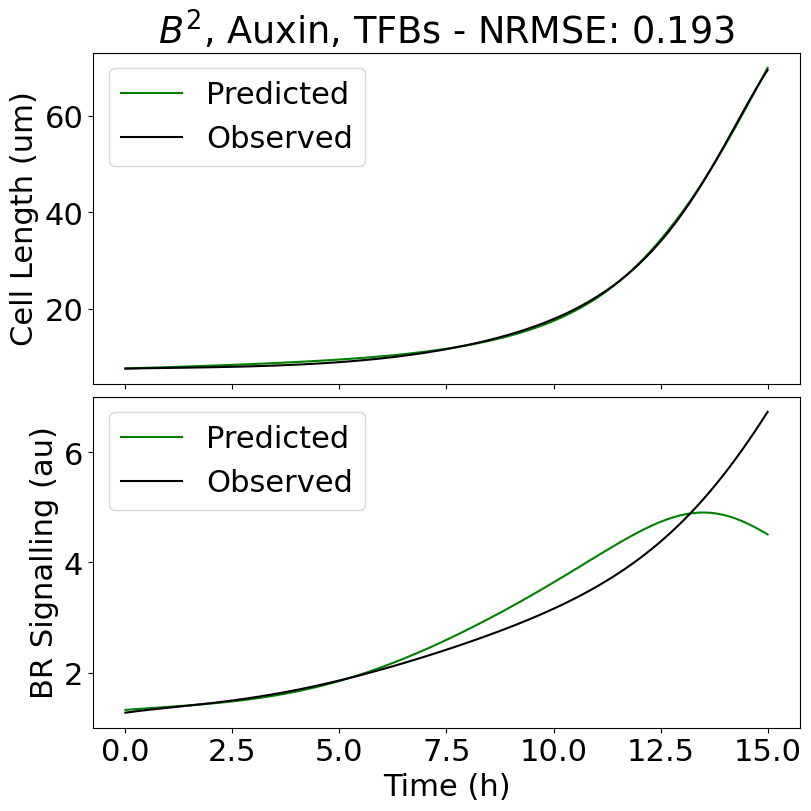

In [25]:
# Plot data from the best overall result
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['font.size'] = 22

config, (vC, vR0, vS, vM, vL), error = sorted_results[0]
description = get_description(config)
fig, (a1, a2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, layout = "constrained")


def plot_axis(a, y1, ylabel, y2 = []):
    a.plot(vT, y1, color = "green", label="Predicted")
    if any(y2): 
        a.plot(vT, y2, color = "black", label = "Observed")
        a.legend()
    a.set_ylabel(ylabel)

a1.set_title(description + " - NRMSE: " + str(round(error, 3)))
plot_axis(a1, vL, "Cell Length (um)", vSIZE)
plot_axis(a2, vS, "BR Signalling (au)", vBES1)  
a2.set_xlabel("Time (h)")

fig.savefig("img/prototype-3d-best-fit.png", bbox_inches = "tight")
plt.show()

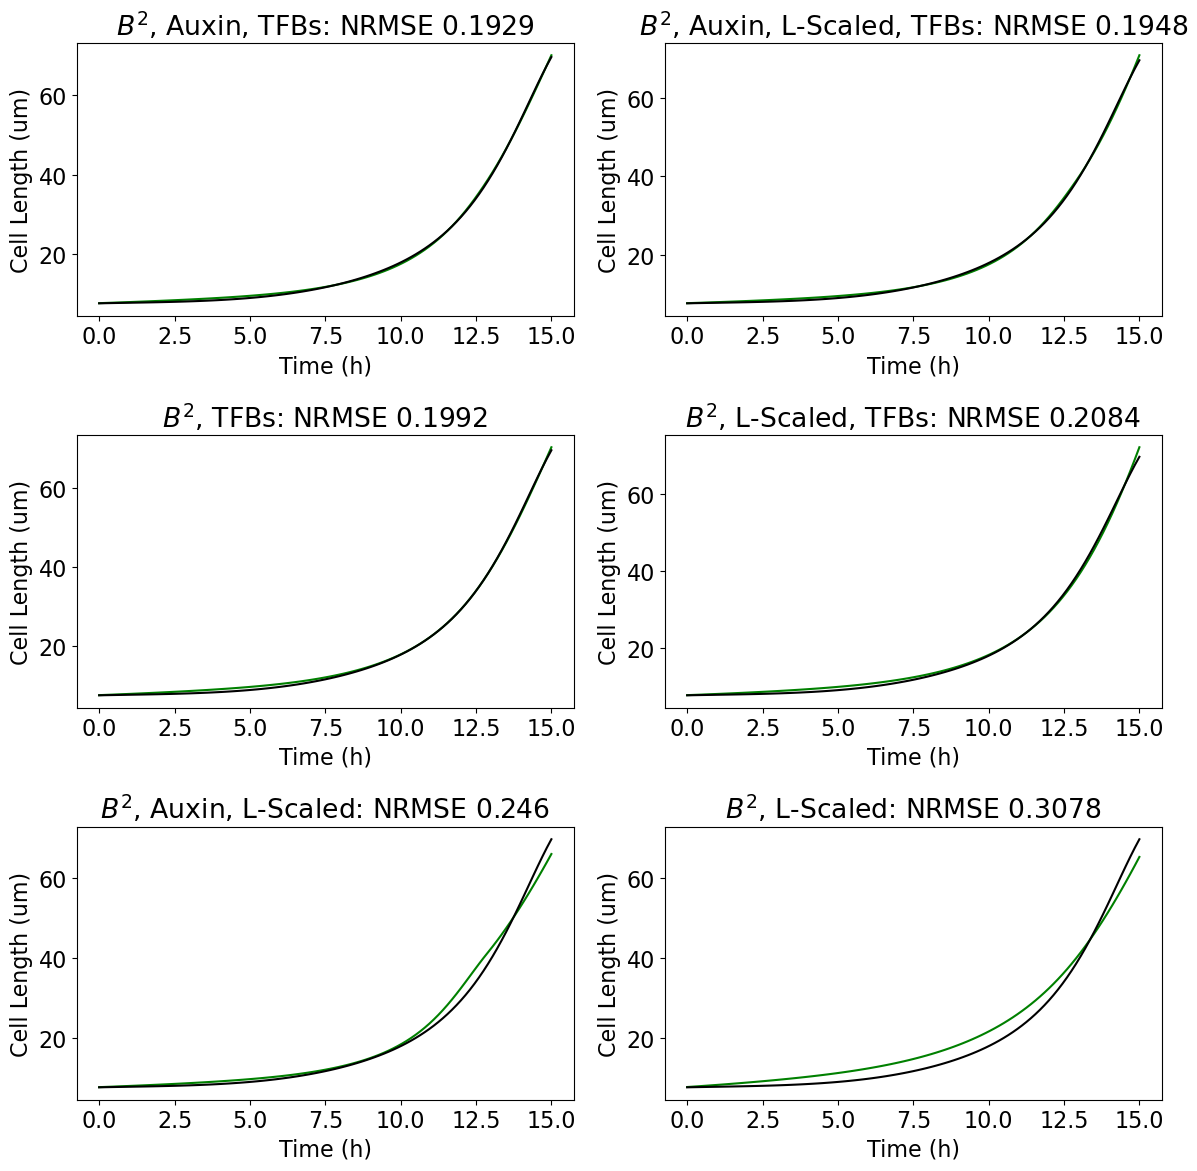

In [12]:
# Plot the six best cell length fits
mpl.rcParams['font.size'] = 16
fig, axes = plt.subplots(nrows = 3, ncols = 2)
axes = [a for row in axes for a in row]

for (a, r) in zip(axes, sorted_results):
    config, (vC, vR0, vS, vM, vL), error = r
    description = get_description(config)
    a.plot(vT, vL, color = "green", label = "Fitted Model")
    a.plot(vT, vSIZE, color = "black", label = "Experimental Data")
    a.set_xlabel("Time (h)")
    a.set_ylabel("Cell Length (um)")
    a.set_title(description + ": NRMSE " + str(round(error, 4)))

plt.tight_layout()
fig.savefig("img/prototype-3d-length-fits.png")

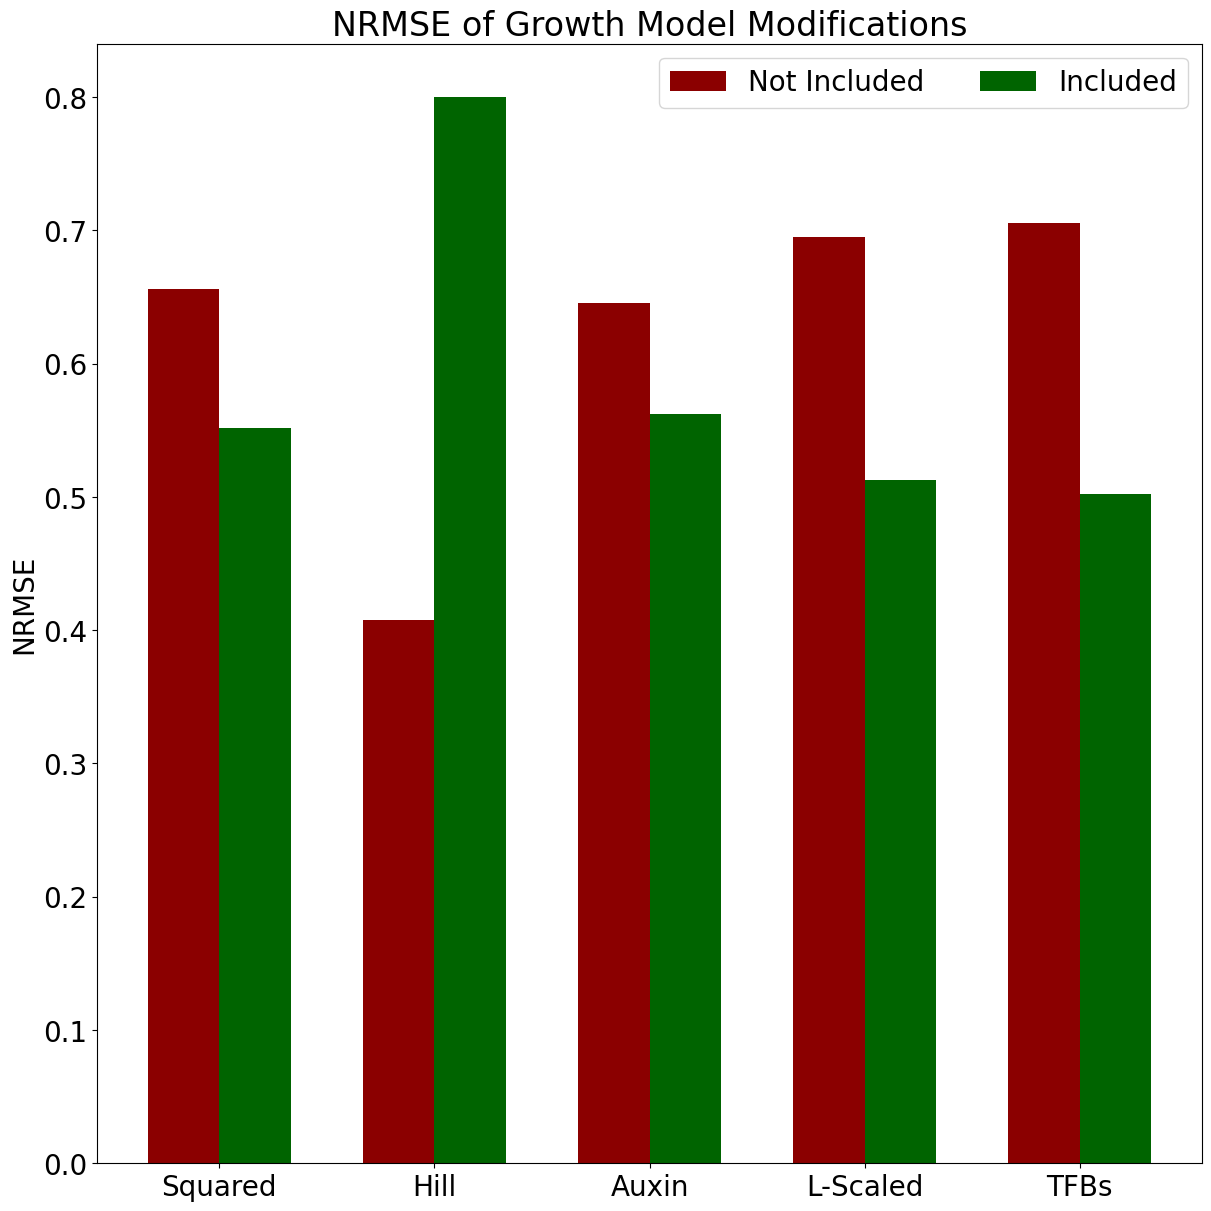

In [13]:
# Plot the mean error of the growth models
XLABELS = ["Squared", "Hill", "Auxin", "L-Scaled", "TFBs"]
bardata = {"Not Included": [], "Included": []}
for i, label in enumerate(XLABELS):
    error_false = sum([r[2] for r in results if r[0][i] == False]) / 16
    error_true  = sum([r[2] for r in results if r[0][i] == True]) / 16
    bardata["Not Included"].append(error_false)
    bardata["Included"].append(error_true)

# Change the colour cycler
colors = ["darkred", "darkgreen"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

# Construct the bar chart
mpl.rcParams['font.size'] = 20
fig, ax = plt.subplots(layout='constrained')
x = np.arange(len(XLABELS))
width, multiplier = 1/3, 0

# Plot the data
for attribute, measurement in bardata.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('NRMSE of Growth Model Modifications')
ax.set_ylabel('NRMSE')
ax.set_ylim(0, None)
ax.set_xticks(x + 1/6, XLABELS)
ax.legend(loc='upper right', ncols=2)
plt.savefig("img/prototype-3d-modification-means.png", bbox_inches = "tight")
plt.show()

In [14]:
# Converts a config tuple into an xy location in 4x8 array
def get_position(config):
    x = sum([config[i] * (2 ** i) for i in range(2)])
    y = sum([config[i+2] * (2 ** i) for i in range(3)])
    return (x, y)

# Define the label arrays
XLABELS = ["", "Auxin", "L-Scaled", "L-Scaled, Auxin", "TFBs", 
           "TFBs, Auxin", "TFBs, L-Scaled", "TFBs, L-Scaled, Auxin"]
YLABELS = [r"$B$", r"$B^2$", r"$B$, Hill", r"$B^2$, Hill"]

# Create a mapping between config and label
mapdata = np.zeros((4, 8))
for r in results:
    config, data, error = r
    x, y = get_position(config)
    mapdata[x][y] = error

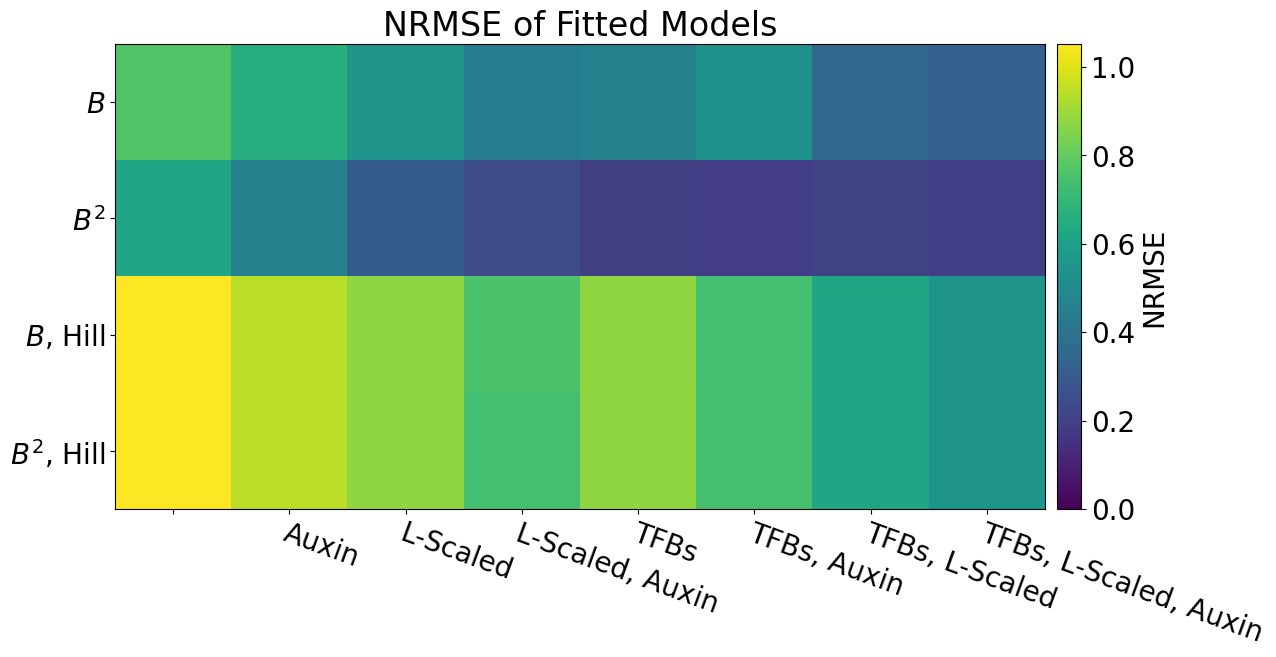

In [15]:
# Generate the heatmap
mpl.rcParams['font.size'] = 20
fig, ax = plt.subplots()
im = ax.imshow(mapdata, vmin = 0, vmax = np.max(mapdata))

# Create a colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = fig.colorbar(im, cax=cax, label = "NRMSE") 
cbar.set_ticks(np.arange(0, np.max(mapdata), 0.2))

# Show all ticks and label them with the respective list entries.
ax.set_xticks(np.arange(8), labels=XLABELS)
ax.set_yticks(np.arange(4), labels=YLABELS)
ax.set_title("NRMSE of Fitted Models")

# Rotate the xtick labels so that they fit
plt.setp(ax.get_xticklabels(), rotation=-20, ha="left", rotation_mode="anchor")
plt.savefig("img/prototype-3d-error-heatmap.png", bbox_inches = "tight")

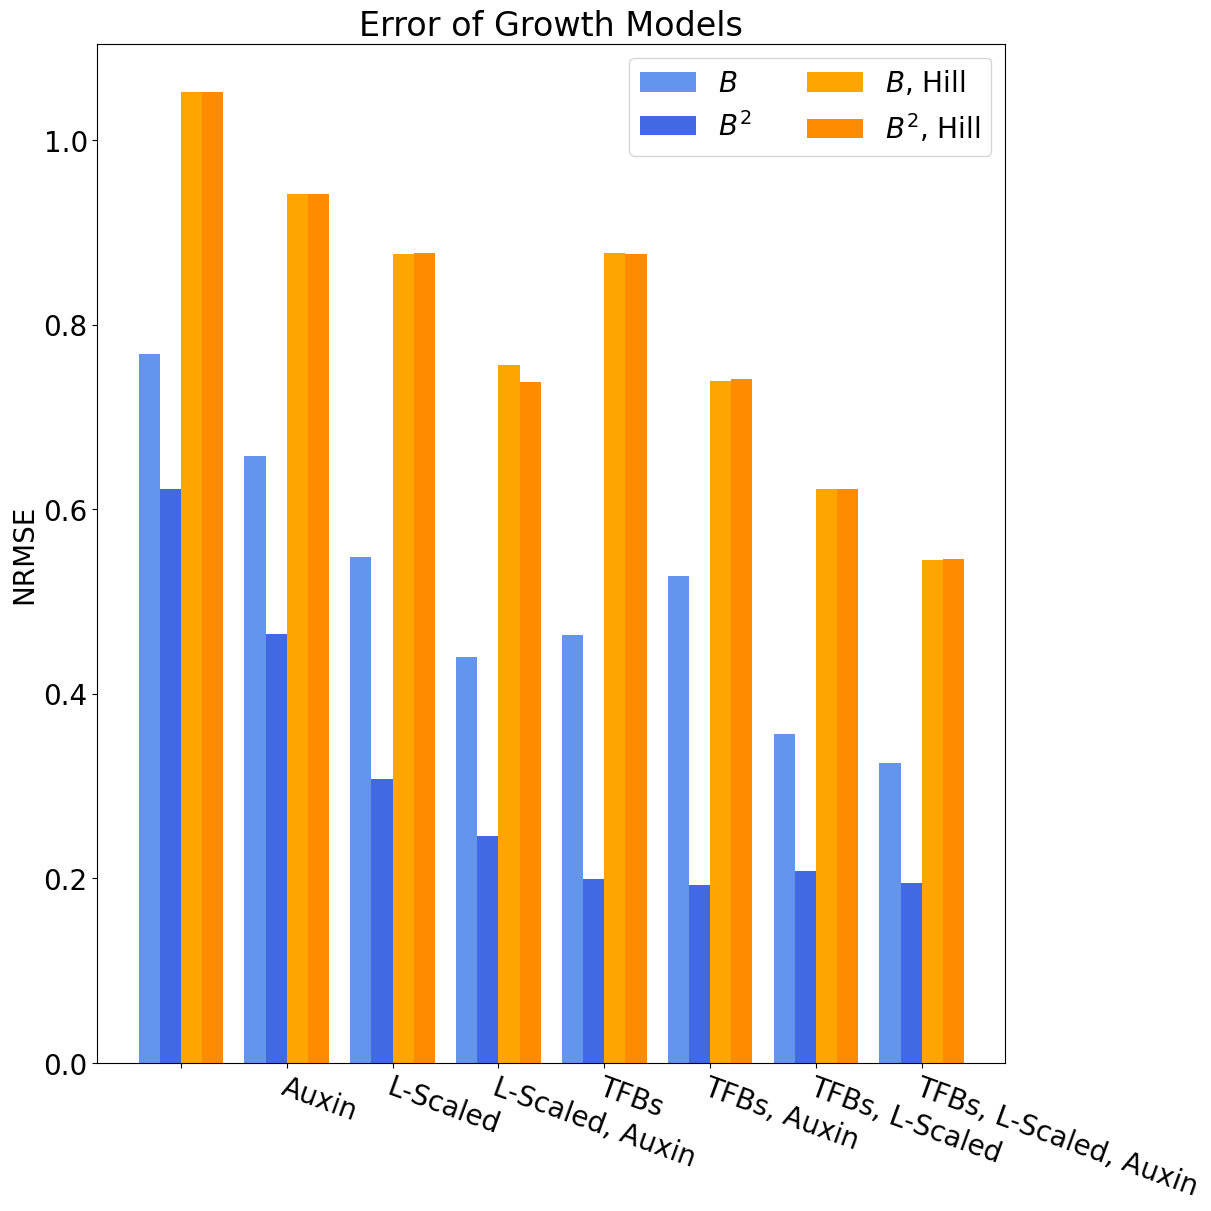

In [16]:
# Produce a dictionary of data and other variables for the bar chart
mpl.rcParams['font.size'] = 20
bardata = {label : row for label, row in zip(YLABELS, mapdata)}
x = np.arange(len(XLABELS)) 
width, multiplier = 0.2, 0

# Change the colour cycler
colors = ["cornflowerblue", "royalblue", "orange", "darkorange"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

# Construct the bar chart
fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in bardata.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Error of Growth Models')
ax.set_ylabel('NRMSE')
ax.set_ylim(0, None)
ax.set_xticks(x + 0.3, XLABELS)
ax.legend(loc='upper right', ncols=2)
plt.setp(ax.get_xticklabels(), rotation=-20, ha="left", rotation_mode="anchor")
plt.savefig("img/prototype-3d-error-barchart.png", bbox_inches = "tight")
plt.show()